In [1]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = 6 #fig_width_pt*inches_per_pt  # width in inches
fig_height = 6 # fig_width*golden_mean*2      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 20,
          'text.fontsize': 16,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)

# --------------- Latex Plot Beautification --------------------------

/shared/users/asousa/software/python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<IPython.core.display.Javascript object>


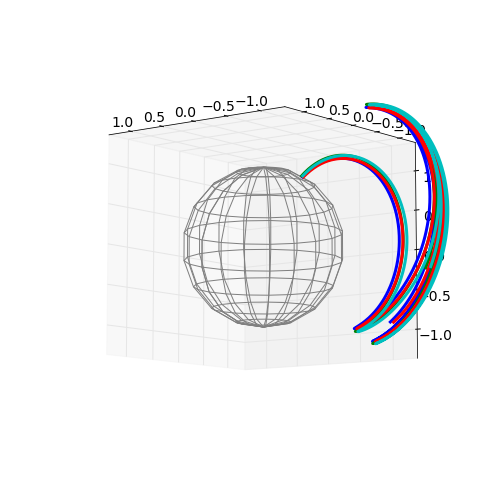

(-2, 2)

In [51]:
# ----- Plot rays (3d version) -----

# Load rayfile:
rf = read_rayfile('/shared/users/asousa/WIPP/3dWIPP/outputs/four_adjacent/rayout_1100_damped.ray')
flashtime = dt.datetime(2015, 1, 1, 0, 0, 0)
R_E = 6371e3 # Radius of earth in meters
D2R = (np.pi/180.0)

psize = 2
# Convert to geographic coordinates for plotting:
rays = []
for r in rf:
    tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
    tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
    tmp_coords.convert('MAG','car')
    tmp_coords.sim_time = r['time']

    rays.append(tmp_coords)


# -------- 3D Plot -------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect("equal")

# Plot the earth
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)
ax.plot_wireframe(x, y, z, color="grey")


# Plot rays:
for r in rays:
    ax.plot(r.x/R_E, r.y/R_E, r.z/R_E, linewidth=3)

ax.set_xlim([-psize, psize])
ax.set_ylim([-psize, psize])
ax.set_zlim([-psize, psize])






<IPython.core.display.Javascript object>


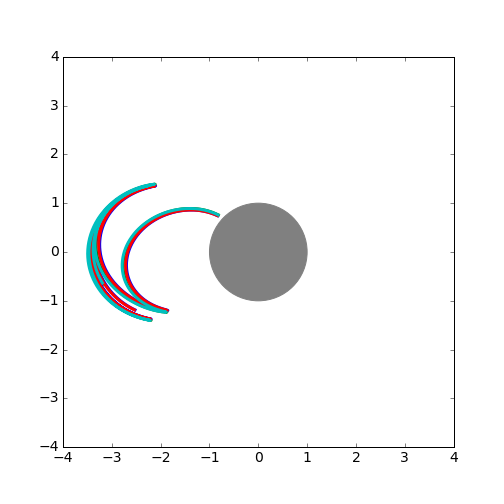

(-4, 4)

In [52]:
# -------- 2D Plot -------------------
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect("equal")
psize = 8
# # Plot the earth
# u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
# x=np.cos(u)*np.sin(v)
# y=np.sin(u)*np.sin(v)
# z=np.cos(v)
# ax.plot_wireframe(x, y, z, color="grey")


# Plot the earth
earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
ax.add_patch(earth)                    # The earth (round)



# Plot rays:
for r in rays:
    ax.plot(r.x/R_E, r.z/R_E, linewidth=3)

ax.set_xlim([-psize/2, psize/2])
ax.set_ylim([-psize/2, psize/2])



IOError: Failed to interpret file '/shared/users/asousa/WIPP/3dWIPP/python/Indices/Kp_raw/Kp_1999_2016.dat' as a pickle

<IPython.core.display.Javascript object>


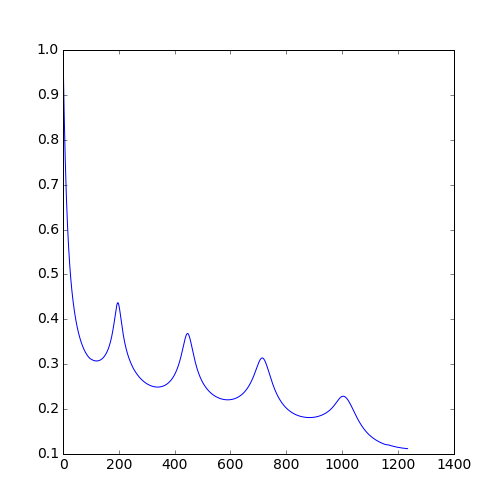

In [49]:
# rf = read_rayfile('/shared/users/asousa/WIPP/3dWIPP/outputs/rayout_damped.ray')

plt.figure()
plt.plot(rf[0]['damping'])

In [21]:
psize = 4;
crossing_log = '/shared/users/asousa/WIPP/3dWIPP/outputs/crossing_log.txt'
EA_dump = '/shared/users/asousa/WIPP/3dWIPP/ea_dump.dat'


cl = np.loadtxt(crossing_log)

ea = np.loadtxt(EA_dump)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect("equal")
# Plot the earth
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x=np.cos(u)*np.sin(v)
y=np.sin(u)*np.sin(v)
z=np.cos(v)
ax.plot_wireframe(x, y, z, color="grey")



ax.scatter(cl[:,0], cl[:,1], cl[:,2])


# Plot rays:
for r in rays:
    ax.plot(r.x/R_E, r.y/R_E, r.z/R_E, linewidth=1)



ax.set_xlim([-psize, 0])
ax.set_ylim([-psize, 0])
ax.set_zlim([-psize/2, psize/2])



ValueError: invalid literal for float(): 0.0300523-0.996226

<IPython.core.display.Javascript object>


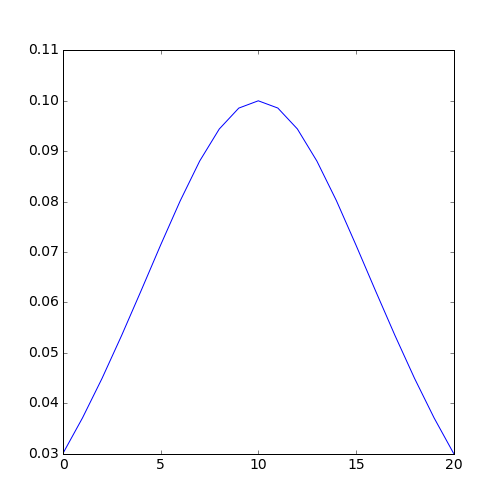

In [24]:
ea = np.loadtxt(EA_dump)

plt.figure()






In [38]:
len(rays)

1